In [68]:
import pandas as pd
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from geopy.distance import great_circle as vc
import math as Math
from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [69]:
df = pd.read_csv(r'indian_new.csv')

In [70]:
display(
    df.head(2), 
    df.dtypes,
    df.columns,
    df.shape,
    df['Status'].unique(), 
    df['Time'].unique(), 
#     df['Date'].min(), 
#     df['Date'].max(),
    df['Status'].value_counts(),
    df['ID'].nunique()
)

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4N,87.0E,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7N,86.5E,25,D,1000,3


ID                            object
Name                          object
Date                           int64
Time                           int64
Latitude                      object
Longitude                     object
Maximum Wind                   int64
Status                        object
Estimated Central Pressure     int64
Pressure Drop                  int64
dtype: object

Index(['ID', 'Name', 'Date', 'Time', 'Latitude', 'Longitude', 'Maximum Wind',
       'Status', 'Estimated Central Pressure', 'Pressure Drop'],
      dtype='object')

(2427, 10)

array(['D', 'DD', 'CS', 'SCS', 'VSCS', 'ESCS', 'SuCS'], dtype=object)

array([   0,  300,  600,  900, 1200, 1500, 1800, 2100], dtype=int64)

CS      686
D       527
DD      427
VSCS    327
SCS     251
ESCS    182
SuCS     27
Name: Status, dtype: int64

80

In [71]:
df["Name"] = df["Name"].str.strip()
df['Date'] = pd.to_datetime(df['Date'], format = '%Y%m%d')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [72]:
df.head(2)

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year,Month
0,A1,AMPHAN,2020-05-16,0,10.4N,87.0E,25,D,1000,3,2020,5
1,A1,AMPHAN,2020-05-16,300,10.7N,86.5E,25,D,1000,3,2020,5


In [73]:
# Assuming 'data' is your DataFrame containing the provided data
# First, ensure that 'Date' and 'Time' columns are combined into a datetime column
df['DateTime'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Sort the data by DateTime in ascending order
df = df.sort_values(by='DateTime')

# Define the lag window size (e.g., 1 hour)
lag_window = 1  # Adjust this value as needed

# Create lag features for 'Maximum Wind', 'Estimated Central Pressure', and 'Pressure Drop'
for feature in ['Maximum Wind', 'Estimated Central Pressure', 'Pressure Drop']:
    for i in range(1, lag_window + 1):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

# Drop rows with NaN values resulting from the lag operation
df.dropna(inplace=True)

# Optionally, you can drop the original 'Date', 'Time', and 'DateTime' columns if they are no longer needed
# df.drop(columns=['Date', 'Time', 'DateTime'], inplace=True)

# Display the updated DataFrame with lag features
df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year,Month,DateTime,Maximum Wind_lag_1,Estimated Central Pressure_lag_1,Pressure Drop_lag_1
2323,O1,01A,2006-01-14,300,5.0N,75.5E,30,DD,1006,4,2006,1,2006-01-14,25.0,1006.0,4.0
2322,O1,01A,2006-01-14,0,5.0N,76.0E,25,D,1006,4,2006,1,2006-01-14,30.0,1006.0,4.0
2329,O1,01A,2006-01-14,2100,7.0N,72.0E,25,D,1006,4,2006,1,2006-01-14,25.0,1006.0,4.0
2328,O1,01A,2006-01-14,1800,7.0N,72.5E,25,D,1004,4,2006,1,2006-01-14,25.0,1006.0,4.0
2324,O1,01A,2006-01-14,600,7.0N,74.0E,30,DD,1006,4,2006,1,2006-01-14,25.0,1004.0,4.0


### `Maximum wind speed information yearwise`

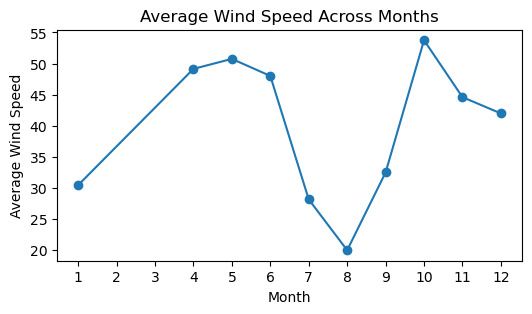

In [74]:
plt.figure(figsize=(6, 3))
df.groupby('Month')['Maximum Wind'].mean().plot(marker='o', linestyle='-')
plt.title('Average Wind Speed Across Months')
plt.xlabel('Month')
plt.ylabel('Average Wind Speed')
plt.xticks(range(1, 13))  # Assuming the month column ranges from 1 to 12
plt.show()

In [75]:
# import plotly.express as px
# fig = px.bar(described_df, x = 'Year', y = 'Data Count', color = 'Mean', color_continuous_scale = px.colors.sequential.OrRd,
#                title = 'Average Wind Speed of Large Storms in Indian Ocean by Year (2001-2020)', labels = {'Count':'Number of Large Storms', 'Mean' : 'Average Wind <br> Speed (knots)'}, text_auto = True)

# plt.tight_layout()
# fig.update_layout(title_x = 0.5)
# fig.show()

### `Number of days of storm each year`

In [76]:
count_df = df.groupby('Year')['Date'].nunique().reset_index(name='Number of days of storm')
count_df = count_df.sort_values(by='Year', ascending=True)

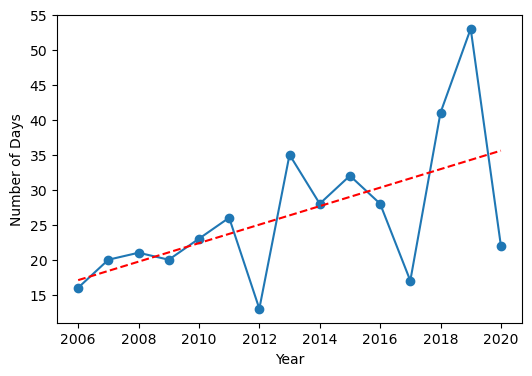

In [77]:
# Fit a linear regression line
coefficients = np.polyfit(count_df['Year'], count_df['Number of days of storm'], 1)
trendline = np.poly1d(coefficients)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(count_df['Year'], count_df['Number of days of storm'], marker='o', linestyle='-', label='Number of Days of Storm')
plt.plot(count_df['Year'], trendline(count_df['Year']), color='red', linestyle='--', label='Trendline')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.show()

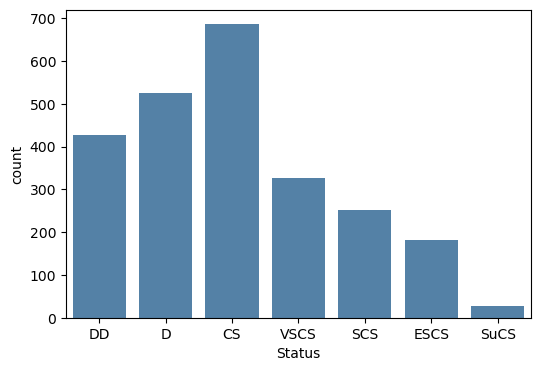

In [78]:
plt.figure(figsize=(6, 4))
sns.countplot(x = 'Status', data = df, color = '#4682B4');

### `Wind Speed Distribution`

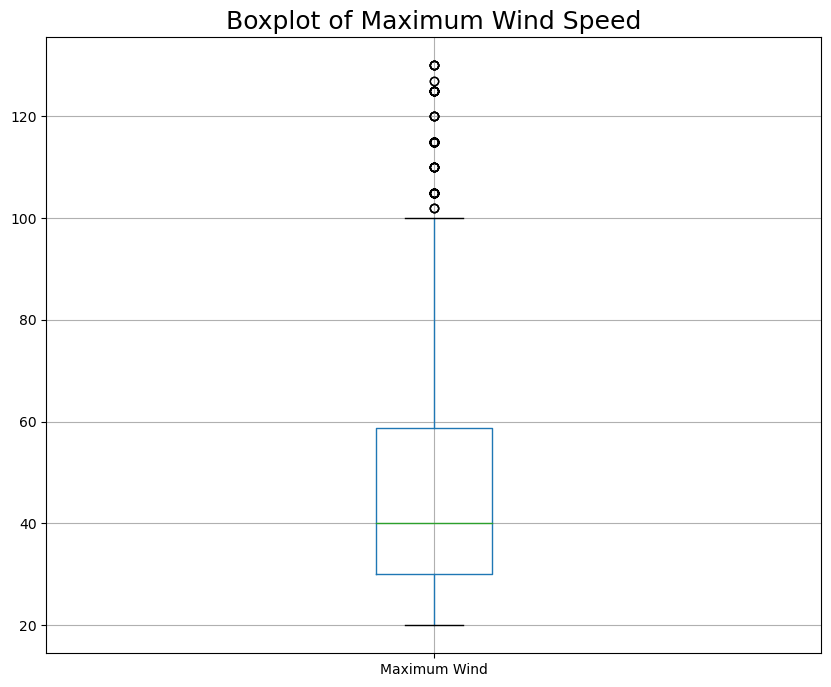

In [79]:
plt.figure(figsize = (10, 8))
fig = df.boxplot(column = 'Maximum Wind').set_title('Boxplot of Maximum Wind Speed', fontsize = 18)

### `Geospatial Analysis`

In [80]:
display(df.head(2), df.shape)

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year,Month,DateTime,Maximum Wind_lag_1,Estimated Central Pressure_lag_1,Pressure Drop_lag_1
2323,O1,01A,2006-01-14,300,5.0N,75.5E,30,DD,1006,4,2006,1,2006-01-14,25.0,1006.0,4.0
2322,O1,01A,2006-01-14,0,5.0N,76.0E,25,D,1006,4,2006,1,2006-01-14,30.0,1006.0,4.0


(2426, 16)

In [81]:
df = df.replace({'N':''}, regex = True)
df = df.replace({'W':''}, regex = True)
df = df.replace({'E':''}, regex = True)
df = df.replace({'S':''}, regex = True)

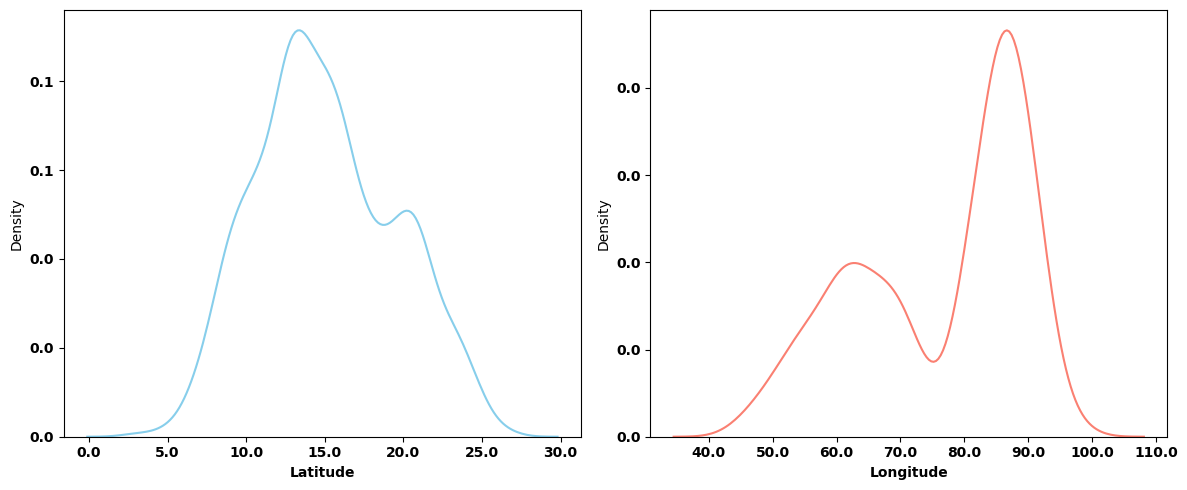

In [82]:
from matplotlib import ticker
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['Longitude'] = pd.to_numeric(df['Longitude'])

# Create separate density plots for latitude and longitude
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(df['Latitude'], color='skyblue')
plt.xlabel('Latitude', fontweight='bold')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1f}"))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1f}"))
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.subplot(1, 2, 2)
sns.kdeplot(df['Longitude'], color='salmon')
plt.xlabel('Longitude', fontweight='bold')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1f}"))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1f}"))
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()

In [83]:
df.head(2)

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year,Month,DateTime,Maximum Wind_lag_1,Estimated Central Pressure_lag_1,Pressure Drop_lag_1
2323,O1,01A,2006-01-14,300,5.0,75.5,30,DD,1006,4,2006,1,2006-01-14,25.0,1006.0,4.0
2322,O1,01A,2006-01-14,0,5.0,76.0,25,D,1006,4,2006,1,2006-01-14,30.0,1006.0,4.0


In [84]:
# map_van = folium.Map(location=[21, 77], zoom_start=5)
# marker_cluster = MarkerCluster().add_to(map_van)

# for idx, row in df2.iterrows():
#     folium.Marker(location=[row['Latitude'], row['Longitude']]).add_to(marker_cluster)

# map_van

### `Trend Analysis`

In [85]:
cyclone_counts_per_year = df.groupby('Year')['ID'].nunique()

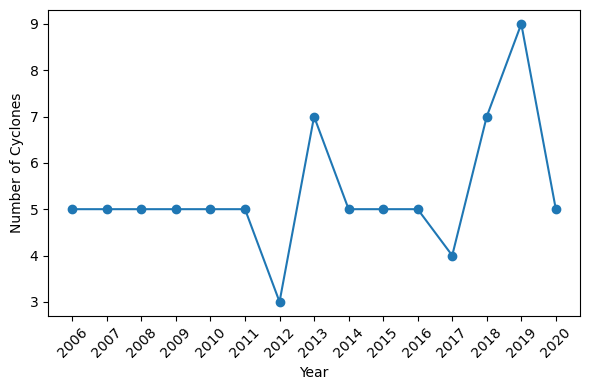

In [86]:
plt.figure(figsize=(6, 4))
plt.plot(cyclone_counts_per_year.index, cyclone_counts_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.xticks(cyclone_counts_per_year.index, rotation=45)
plt.tight_layout()
plt.show()

### `Machine Learning`

In [87]:
df.isnull().sum()

ID                                  0
Name                                0
Date                                0
Time                                0
Latitude                            0
Longitude                           0
Maximum Wind                        0
Status                              0
Estimated Central Pressure          0
Pressure Drop                       0
Year                                0
Month                               0
DateTime                            0
Maximum Wind_lag_1                  0
Estimated Central Pressure_lag_1    0
Pressure Drop_lag_1                 0
dtype: int64

In [88]:
df.head(2)

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year,Month,DateTime,Maximum Wind_lag_1,Estimated Central Pressure_lag_1,Pressure Drop_lag_1
2323,O1,01A,2006-01-14,300,5.0,75.5,30,DD,1006,4,2006,1,2006-01-14,25.0,1006.0,4.0
2322,O1,01A,2006-01-14,0,5.0,76.0,25,D,1006,4,2006,1,2006-01-14,30.0,1006.0,4.0


In [89]:
df_ml = df.copy()
df_ml.drop(columns = ['ID', 'Name', 'Date', 'Time', 'Year', 'Month', 'Maximum Wind'], inplace = True)

In [90]:
df_ml.head(2)

,Latitude,Longitude,Status,Estimated Central Pressure,Pressure Drop,DateTime,Maximum Wind_lag_1,Estimated Central Pressure_lag_1,Pressure Drop_lag_1
2323,5.0,75.5,DD,1006,4,2006-01-14,25.0,1006.0,4.0
2322,5.0,76.0,D,1006,4,2006-01-14,30.0,1006.0,4.0


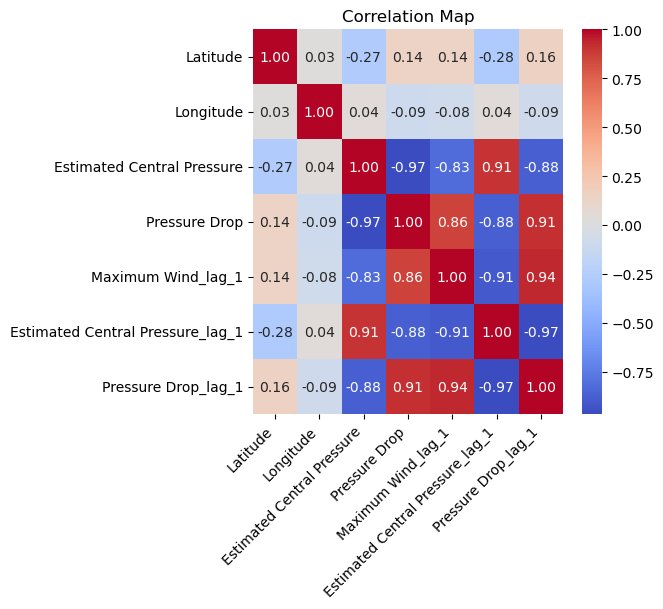

In [91]:
correlation_matrix = df_ml.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation = 0)
plt.title('Correlation Map')
plt.show()

In [64]:
#Drop highly correlated features
threshold = 0.7  
corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            corr_features.add(colname)

df_ml = df_ml.drop(corr_features, axis=1)

In [65]:
df_ml.head(2)

,Latitude,Longitude,Status,Estimated Central Pressure,DateTime
2323,5.0,75.5,DD,1006,2006-01-14
2322,5.0,76.0,D,1006,2006-01-14


In [66]:
# Define x_train and y_train after dropping correlated features
x_train = df_ml.drop(['Status'], axis=1)
y_train = df_ml['Status']

In [1047]:
x_train.head(2)

,Latitude,Longitude,Estimated Central Pressure
0,10.4,87.0,1000
1,10.7,86.5,1000


In [1048]:
y_train.head(2)

0    D
1    D
Name: Status, dtype: object

In [1049]:
# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [1050]:
# Create a DataFrame
df_metrics = pd.DataFrame(columns=['ml_classifier', 'avg_acc', 'avg_prec', 'avg_recall'])

`1. Decision Tree`

In [1051]:
# Initialize Decision Tree classifier
dt_classifier = DecisionTreeClassifier(min_samples_leaf=50 , criterion='entropy')

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x_train):
    # Split data into training and testing sets for this fold
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the Decision Tree classifier
    dt_classifier.fit(x_train_fold, y_train_fold)
    
    # Make predictions on the test data
    y_pred = dt_classifier.predict(x_test_fold)
    
    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred, average='weighted')
    recall = recall_score(y_test_fold, y_pred, average='weighted')
    
    # Append evaluation metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate average evaluation metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Accuracy: 0.7362954477960206
Average Precision: 0.7267398270685151
Average Recall: 0.7362954477960206


In [1052]:
df_metrics = df_metrics.append({'ml_classifier': 'Decision Tree',
                                'avg_acc': average_accuracy,
                                'avg_prec': average_precision,
                                'avg_recall': average_recall}, ignore_index=True)

In [1053]:
df_metrics.head()

,ml_classifier,avg_acc,avg_prec,avg_recall
0,Decision Tree,0.736295,0.72674,0.736295


`2. Random Forest`

In [1054]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=50, criterion='entropy')

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x_train):
    # Split data into training and testing sets for this fold
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the Random Forest classifier
    rf_classifier.fit(x_train_fold, y_train_fold)
    
    # Make predictions on the test data
    y_pred = rf_classifier.predict(x_test_fold)
    
    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred, average='weighted')
    recall = recall_score(y_test_fold, y_pred, average='weighted')
    
    # Append evaluation metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate average evaluation metrics across all folds
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Accuracy: 0.739188833736371
Average Precision: 0.7263306903934714
Average Recall: 0.739188833736371


In [1055]:
df_metrics = df_metrics.append({'ml_classifier': 'Random Forest',
                                'avg_acc': average_accuracy,
                                'avg_prec': average_precision,
                                'avg_recall': average_recall}, ignore_index=True)

In [1056]:
df_metrics.head()

,ml_classifier,avg_acc,avg_prec,avg_recall
0,Decision Tree,0.736295,0.726740,0.736295
1,Random Forest,0.739189,0.726331,0.739189


3. Naive Bayes

In [1057]:
nb_classifier = GaussianNB()

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x_train):
    # Split data into training and testing sets for this fold
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the Naive Bayes classifier
    nb_classifier.fit(x_train_fold, y_train_fold)
    
    # Make predictions on the test data
    y_pred = nb_classifier.predict(x_test_fold)
    
    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred, average='weighted')
    recall = recall_score(y_test_fold, y_pred, average='weighted')
    
    # Append evaluation metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate average evaluation metrics across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Accuracy: 0.5372814051164566
Average Precision: 0.5726829757883393
Average Recall: 0.5372814051164566


In [1058]:
df_metrics = df_metrics.append({'ml_classifier': 'Naive Bayes',
                                'avg_acc': average_accuracy,
                                'avg_prec': average_precision,
                                'avg_recall': average_recall}, ignore_index=True)

In [1059]:
df_metrics.head()

,ml_classifier,avg_acc,avg_prec,avg_recall
0,Decision Tree,0.736295,0.726740,0.736295
1,Random Forest,0.739189,0.726331,0.739189
2,Naive Bayes,0.537281,0.572683,0.537281


4. Support Vector Machine

In [1060]:
# Initialize Support Vector Machine classifier
svm_classifier = SVC(C=10000, kernel='rbf')

# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x_train):
    # Split data into training and testing sets for this fold
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the SVM classifier
    svm_classifier.fit(x_train_fold, y_train_fold)
    
    # Make predictions on the test data
    y_pred = svm_classifier.predict(x_test_fold)
    
    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred, average='weighted')
    recall = recall_score(y_test_fold, y_pred, average='weighted')
    
    # Append evaluation metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate average evaluation metrics across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Accuracy: 0.6732586653090662
Average Precision: 0.6513081035439998
Average Recall: 0.6732586653090662


In [1061]:
df_metrics = df_metrics.append({'ml_classifier': 'Support Vector Machine',
                                'avg_acc': average_accuracy,
                                'avg_prec': average_precision,
                                'avg_recall': average_recall}, ignore_index=True)

In [1062]:
df_metrics.head()

,ml_classifier,avg_acc,avg_prec,avg_recall
0,Decision Tree,0.736295,0.726740,0.736295
1,Random Forest,0.739189,0.726331,0.739189
2,Naive Bayes,0.537281,0.572683,0.537281
3,Support Vector Machine,0.673259,0.651308,0.673259


5. Gradient Boosting Machine

In [1063]:
# Initialize Gradient Boosting Machine classifier
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)


# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(x_train):
    # Split data into training and testing sets for this fold
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the GBM classifier
    gbm_classifier.fit(x_train_fold, y_train_fold)
    
    # Make predictions on the test data
    y_pred = gbm_classifier.predict(x_test_fold)
    
    # Calculate evaluation metrics for this fold
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred, average='weighted')
    recall = recall_score(y_test_fold, y_pred, average='weighted')
    
    # Append evaluation metrics to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate average evaluation metrics across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Accuracy: 0.8207602562470833
Average Precision: 0.8167991424136097
Average Recall: 0.8207602562470833


In [1064]:
df_metrics = df_metrics.append({'ml_classifier': 'Gradient Boosting',
                                'avg_acc': average_accuracy,
                                'avg_prec': average_precision,
                                'avg_recall': average_recall}, ignore_index=True)

In [1065]:
df_metrics.head()

,ml_classifier,avg_acc,avg_prec,avg_recall
0,Decision Tree,0.736295,0.726740,0.736295
1,Random Forest,0.739189,0.726331,0.739189
2,Naive Bayes,0.537281,0.572683,0.537281
3,Support Vector Machine,0.673259,0.651308,0.673259
4,Gradient Boosting,0.820760,0.816799,0.820760


### `trajectories of cyclones`

In [885]:
#Create a unique key for all of the cyclones
df['ID'] = df['ID']+ '-' + df['Name']

In [886]:
display(df.head(2), df.dtypes)

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year,Month
0,A1-AMPHA,AMPHA,2020-05-16,0,10.4,87.0,25,D,1000,3,2020,5
1,A1-AMPHA,AMPHA,2020-05-16,300,10.7,86.5,25,D,1000,3,2020,5


ID                                    object
Name                                  object
Date                          datetime64[ns]
Time                                   int64
Latitude                              object
Longitude                             object
Maximum Wind                           int64
Status                                object
Estimated Central Pressure             int64
Pressure Drop                          int64
Year                                   int64
Month                                  int64
dtype: object

In [887]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

In [888]:
total_cyclone_count = len(pd.unique(df['ID']))
print(total_cyclone_count)

80


In [889]:
# Since our unique keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(df['ID'])))

y = np.zeros((total_cyclone_count))
for x in range(0, total_cyclone_count):
    y[x] = len(pd.DataFrame(df[df['ID'] == keys[x][1]], columns = df.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each cyclone contains 
cyclone_amount = pd.DataFrame(y)

In [890]:
total_data_count = len(df)
print(total_data_count)

2427


In [891]:
df['distance'] = np.zeros(total_data_count)
df['direction'] = np.zeros(total_data_count)

In [892]:
# For all cyclones
for x in range(0, total_cyclone_count):
    t = pd.DataFrame(df[df['ID'] == keys[x][1]], columns = df.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    
    # For all latitude and longitude points of cyclones, calculate the angle of travel and distance
    for p in zip(t['Latitude'], t['Longitude']):
        
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        #data.set_value(t[(t['Latitude'] == p[0]) & (t['Longitude'] == p[1])]['index'].values[0], 'distance', vc(prev,p).miles)
        df.at[t[(t['Latitude'] == p[0]) & (t['Longitude'] == p[1])]['index'].values[0], 'distance'] = vc(prev, p).miles

        dLon = p[1] - prev[1];  
        temp = float(p[0])
        y_x = Math.sin(dLon) * Math.cos(temp);
        
        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        #data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction', brng)
        df.at[t[(t['Latitude'] == p[0]) & (t['Longitude'] == p[1])]['index'].values[0], 'direction'] = brng

        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
cyclone_distance = pd.DataFrame(y)

In [893]:
# Print the cyclone key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in cyclone_distance.nlargest(6, 0).index:
    print (keys[x][1], ":", cyclone_distance.loc[x][0], "(miles:", cyclone_amount.loc[x][0], ")")

Top 6 Hurricanes (in terms of distance traveled)
C6-GAJA : 2138.1500415889195 (miles: 2138.1500415889195 )
B2-FAI : 1870.4125150459786 (miles: 1870.4125150459786 )
H1-VIYARU : 1856.8997270549241 (miles: 1856.8997270549241 )
B6-MAHA : 1800.4804197719234 (miles: 1800.4804197719234 )
B5-KYARR : 1707.2186764395922 (miles: 1707.2186764395922 )
G3-HUDHUD : 1634.6889097913004 (miles: 1634.6889097913004 )


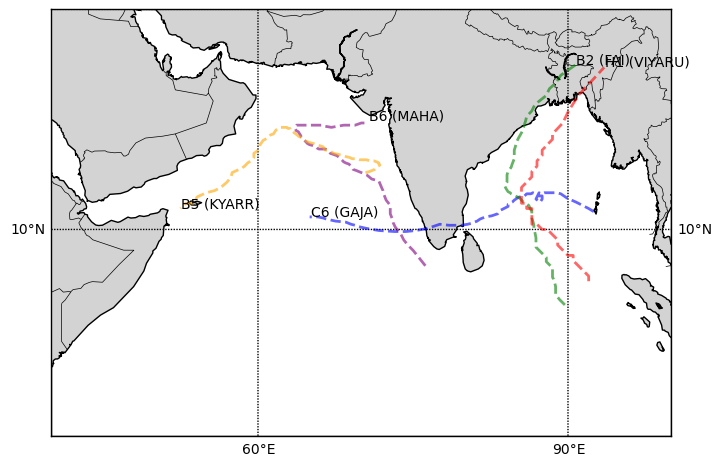

In [902]:
colors = ['blue', 'green', 'red', 'purple', 'orange']
n = 5  # Number of cyclones
plt.figure(figsize=(8, 8))
m = Basemap(llcrnrlon=40., llcrnrlat=-10., urcrnrlon=100., urcrnrlat=30., rsphere=(6378137.00, 6356752.3142),
            resolution='l', projection='merc', lat_0=40., lon_0=-20., lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10, 90, 20), labels=[1, 1, 0, 1])
m.drawmeridians(np.arange(-180, 180, 30), labels=[1, 1, 0, 1])
for i, x in enumerate(cyclone_amount.nlargest(n, 0).index):
    largest_hurr = df[df['ID'] == keys[x][1]]
    lat = largest_hurr['Latitude'].values
    long = largest_hurr['Longitude'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[-1] + 10000, ypt[-1] + 10000, '%s (%s)' % (keys[x][1].split('-')[0], keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color=colors[i], linestyle='dashed', alpha=0.6)



plt.show()

Text(0.5, 0.15, 'Trajectories of the smallest cyclones')

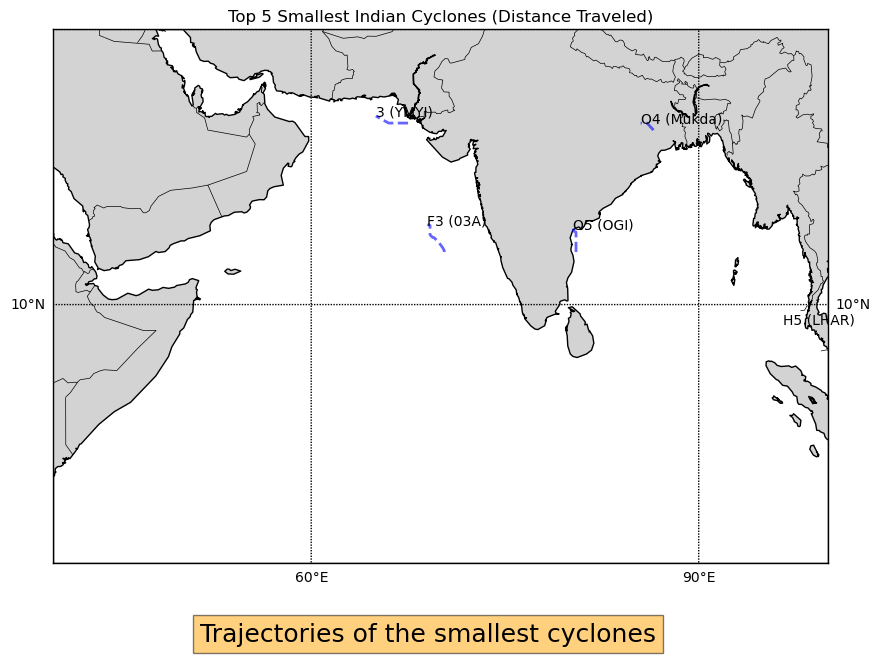

In [895]:
n = 5 # Number of hurricanes

plt.figure(figsize=(10,10))
m = Basemap(llcrnrlon=40.,llcrnrlat=-10.,urcrnrlon=100.,urcrnrlat=30., rsphere=(6378137.00,6356752.3142), resolution='l', projection='merc', lat_0=40.,lon_0=-20.,lat_ts=20.)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in cyclone_amount.nsmallest(n,0).index:
    largest_hurr = df[df['ID'] == keys[x][1]]
    lat = largest_hurr['Latitude'].values
    long = largest_hurr['Longitude'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1],ypt[len(long) - 1], '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue', alpha = 0.6, linestyle = 'dashed')
    
plt.title('Top 5 Smallest Indian Cyclones (Distance Traveled)')
plt.figtext(0.5, 0.15, "Trajectories of the smallest cyclones", ha = "center", fontsize = 18, bbox = {"facecolor": "orange", "alpha": 0.5, "pad": 5})

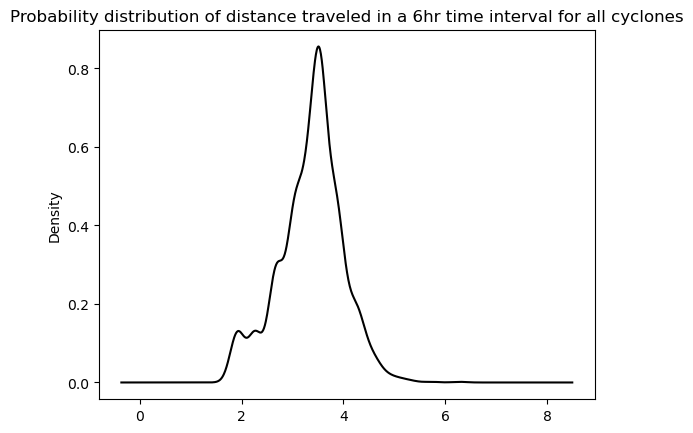

In [896]:
dist = df[df['distance'] > 0]['distance']
dist = np.log(dist)
ser = pd.Series(dist)
ser.plot(kind = 'kde', cmap = 'gray')
plt.title("Probability distribution of distance traveled in a 6hr time interval for all cyclones", loc = 'center');

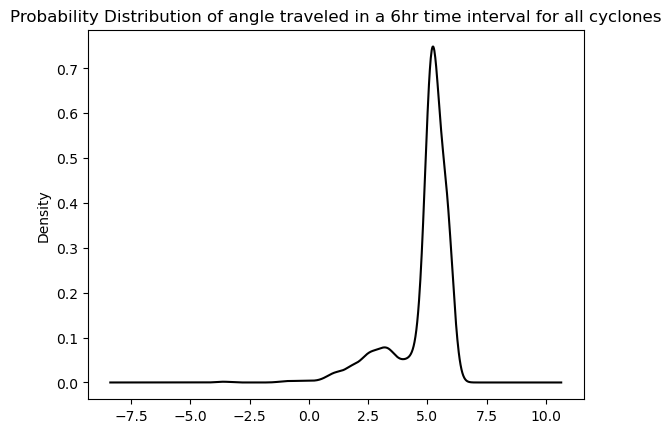

In [897]:
direc = df[df['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot(kind='kde', cmap='gray')
plt.title('Probability Distribution of angle traveled in a 6hr time interval for all cyclones');

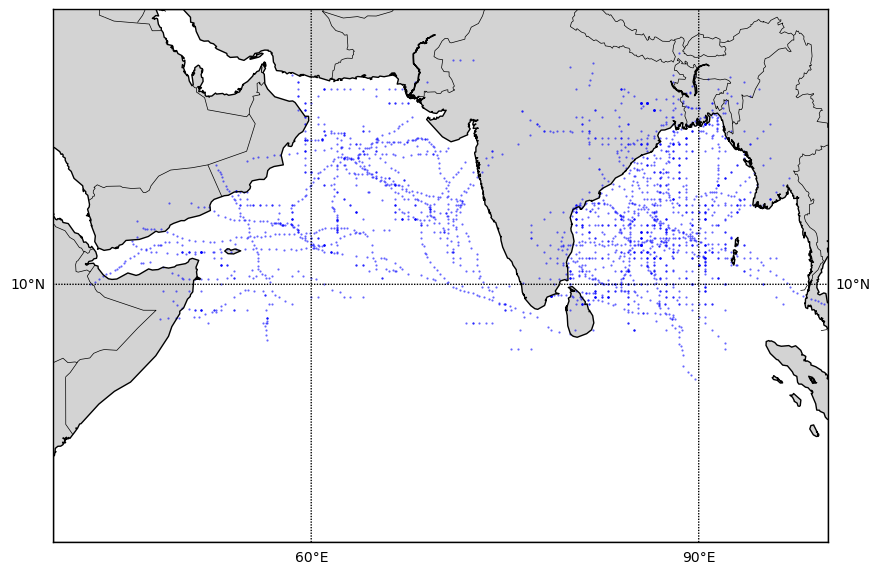

In [898]:
# Graph all points 
plt.figure(figsize=(10, 10))
m = Basemap(llcrnrlon = 40., llcrnrlat = -10., urcrnrlon = 100., urcrnrlat = 30., rsphere = (6378137.00,6356752.3142), resolution = 'l', projection = 'merc', lat_0 = 40., lon_0 = -20., lat_ts = 20.)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = df['Latitude'].values
long = df['Longitude'].values
xpt, ypt = m(long, lat)
m.scatter(xpt, ypt, .3, color = 'blue', alpha = 0.6)
plt.title('Scatterplot of Indian cyclones')